# Reservoirs tables - GloFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 01-12-2024<br>

**Introduction:**<br>

* [ ] 100-year return period of inflow
* [ ] average inflow
* [ ] environmental flow?
* [ ] storage capacity
* [ ] catchment area
* [ ] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cf

import sys
sys.path.append('E:/casadje/GitHub/lisflood-utilities/src/')
from lisfloodutilities.thresholds import compute_thresholds_gumbel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes

## Configuration

In [2]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_GLOFAS5 = Path('Z:/nahaUsers/casadje/GloFASv5')
PATH_GRAND = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')
PATH_GLWD = Path('Z:/nahaUsers/casadje/datasets/lakes/GLWD')
PATH_ICOLD= Path('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023')
PATH_OUT = PATH_GLOFAS5 / 'reservoirs' / 'tables'

# minimum storage capacity included in GloFAS
MIN_VOLUME = 100 # hm³
MIN_CATCHMENT = 500 # km²
MIN_AREA = None # 50 # km2
MIN_DOR = 0.08 #

In [3]:
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

## Data

### GloFAS5

In [21]:
# import TXT of relocated reservoirs
# glofas5 = pd.read_csv(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'reservoirGlofas_20241202.txt', sep='\t')
glofas5 = pd.read_excel(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'reservoirs_glofas5.xlsx', sheet_name='20241202')
id_cols = ['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID']
coord_cols = ['Xlisf', 'Ylisf']
glofas5[id_cols + coord_cols] = glofas5[id_cols + coord_cols].replace(0, np.nan)
glofas5[id_cols] = glofas5[id_cols].astype('Int64')

In [24]:
# add international code from ICOLD
map_icold = gpd.read_file(PATH_GLOFAS5 / 'reservoirs' / 'reservoirs_glofas5.shp')[['RES_ID', 'GRAND_ID', 'INT_CODE']]
map_icold = map_icold[map_icold.INT_CODE.notnull()]
map_res_icold = {res_id: icold_id for res_id, icold_id in zip(map_icold.RES_ID, map_icold.INT_CODE) if pd.notna(res_id)}
map_grand_icold = {grand_id: icold_id for grand_id, icold_id in zip(map_icold.GRAND_ID, map_icold.INT_CODE) if pd.notna(grand_id)}
glofas5['INT_CODE'] = glofas5.GRAND_ID.map(map_grand_icold)
mask_icold = glofas5[glofas5.INT_CODE.isnull()].index
glofas5.loc[mask_icold, 'INT_CODE'] = glofas5.loc[mask_icold, 'RES_ID'].map(map_res_icold)

In [25]:
# keep reservoirs relocated in the LISFLOOD grid
glofas5 = glofas5[glofas5.Xlisf.notnull() & glofas5.Ylisf.notnull()]

# convert to GeoPandas
glofas5 = gpd.GeoDataFrame(glofas5, geometry=[Point(xy) for xy in zip(glofas5.Xlisf, glofas5.Ylisf)], crs='epsg:4326')

# assing ID in descending order of storage capacity
glofas5.sort_values('CAP_MCM', ascending=False, inplace=True)
glofas5.reset_index(drop=True, inplace=True)
glofas5.index.name = 'ID'
glofas5.drop('FID_1', axis=1, errors='ignore', inplace=True)
glofas5 = glofas5[['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']]

print(glofas5.shape)

(1196, 6)


### GloFAS4

#### Reservoirs

In [26]:
# load shapefile
glofas4 = gpd.read_file(PATH_GLOFAS4 / 'tables' / 'GloFAS_reservoirs.shp')

# assign ID
map_ID = {ResID: ID for ID, ResID in zip(glofas5.index, glofas5.RES_ID) if not pd.isna(ResID)}
glofas4['ID'] = glofas4.ResID.map(map_ID).astype('Int64')

# keep reservoirs in GloFAS4 also in GloFAS5
glofas4.dropna(subset=['ID'], inplace=True)
glofas4.set_index('ID', drop=False, inplace=True)

print(glofas4.shape)

(471, 34)


#### Static maps

In [27]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

#### Natural flow

I have run the tool `ncextract` on the EFASv5 long-term run simulation with natural flow, i.e, no reservoirs and no water abstraction. The discharge files resulting from this simulation are in the HPC: `/mnt/DISASTER/FLOODS/nahaUsers/grimast/EFASNatflow/`.

The discharge time series extracted for the reservoir locations are proxies of the reservoir inflow. From these time series we need to estimate the 100-year return period, average inflow and environmental flow.

In [28]:
# # export CSV needed to run `ncextract`
# points = pd.concat((glofas5.geometry.x, glofas5.geometry.y), axis=1)
# points.columns = ['lon', 'lat']
# points.to_csv(PATH_GLOFAS5 / 'reservoirs' / 'ncextract' / 'reservoirs_glofas5_1545.csv')

In [29]:
# # daily timeseries of naturalised discharge
# dis_nat = xr.open_dataset(PATH_GLOFAS5 / 'reservoirs' / 'ncextract' / 'nat_dis_GLOFAS4_1545.nc')['dis']
# dis_nat = dis_nat.sel(time=slice('1993-01-02', None))
# dis_nat.close()

In [30]:
# # 10th percentile of the natural flow
# dis_env_nat = xr.open_dataset(PATH_GLOFAS4 / 'natural_flow' / 'dis_all20_pctl10.nc')['dis'].squeeze('time')

#### Long-term run
Average and 100-year discharge in the long-term run.

In [31]:
# average discharge
dis_avg_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'thresholds' / 'disavg_1979_2023.nc').squeeze(dim='time')
dis_avg_ltr.close()

# 100-year discharge
dis_100_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'thresholds' / 'flood_threshold_glofas_v4_rl_100.0.nc').squeeze(dim='band')

### GRanD

In [32]:
# load raw dataset
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp')

# connection between GRanD and ID
map_grand_ID = {grand_id: ID for ID, grand_id in zip(glofas5.index, glofas5.GRAND_ID) if not pd.isna(grand_id)}
grand['ID'] = grand.GRAND_ID.map(map_grand_ID).astype('Int64')
grand = grand[grand.ID.notnull()]
grand.set_index('ID', drop=True, inplace=True)

print(grand.shape)

(1168, 59)


### GLWD

In [44]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp')#.set_index('GLWD_ID', drop=True)
glwd1 = glwd1[glwd1.GLWD_ID.isin(glofas5.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp')#.set_index('GLWD_ID', drop=True)
glwd2 = glwd2[glwd2.GLWD_ID.isin(glofas5.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == glofas5.GLWD_ID.notnull().sum():
    print('The number of lakes in "glwd" does not match the number of lakes in "glofas5" with assigned GLWD_ID')

# connection between GLWD and ID
map_glwd_ID = {glwd_id: ID for ID, glwd_id in glofas5.GLWD_ID.items() if not pd.isna(glwd_id)}
glwd['ID'] = glwd.GLWD_ID.map(map_glwd_ID).astype('Int64')
glwd = glwd[glwd.ID.notnull()]
glwd.set_index('ID', drop=True, inplace=True)

print(glwd.shape)

(486, 29)


### ICOLD

In [45]:
# load ICOLD dataset
icold = gpd.read_file(PATH_ICOLD / 'ICOLD_global.shp')

# connection between ICOLD and ID
map_icold_ID = {icold_id: ID for ID, icold_id in glofas5.INT_CODE.items() if pd.notna(icold_id)}
icold['ID'] = icold.Int_Code.map(map_icold_ID).astype('Int64')
icold = icold[icold.ID.notnull()]
icold.set_index('ID', drop=True, inplace=True)

print(icold.shape)

(491, 44)


## Attributes

### Capacity

In [46]:
capacity = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
capacity.SOURCE = capacity.SOURCE.astype(str)

# GLOFAS4
capacity.loc[glofas4.index, 'GLOFAS4'] = glofas4.stor

# GRanD
capacity.loc[grand.index, 'GRAND'] = grand.CAP_MCM

# GLWD
capacity.loc[glwd.index, 'GLWD'] = glwd.VOLUME_CKM * 1e3

# ICOLD
capacity.loc[icold.index, 'ICOLD'] = icold.Res_Vol.values * 1e-3

#### Comparison

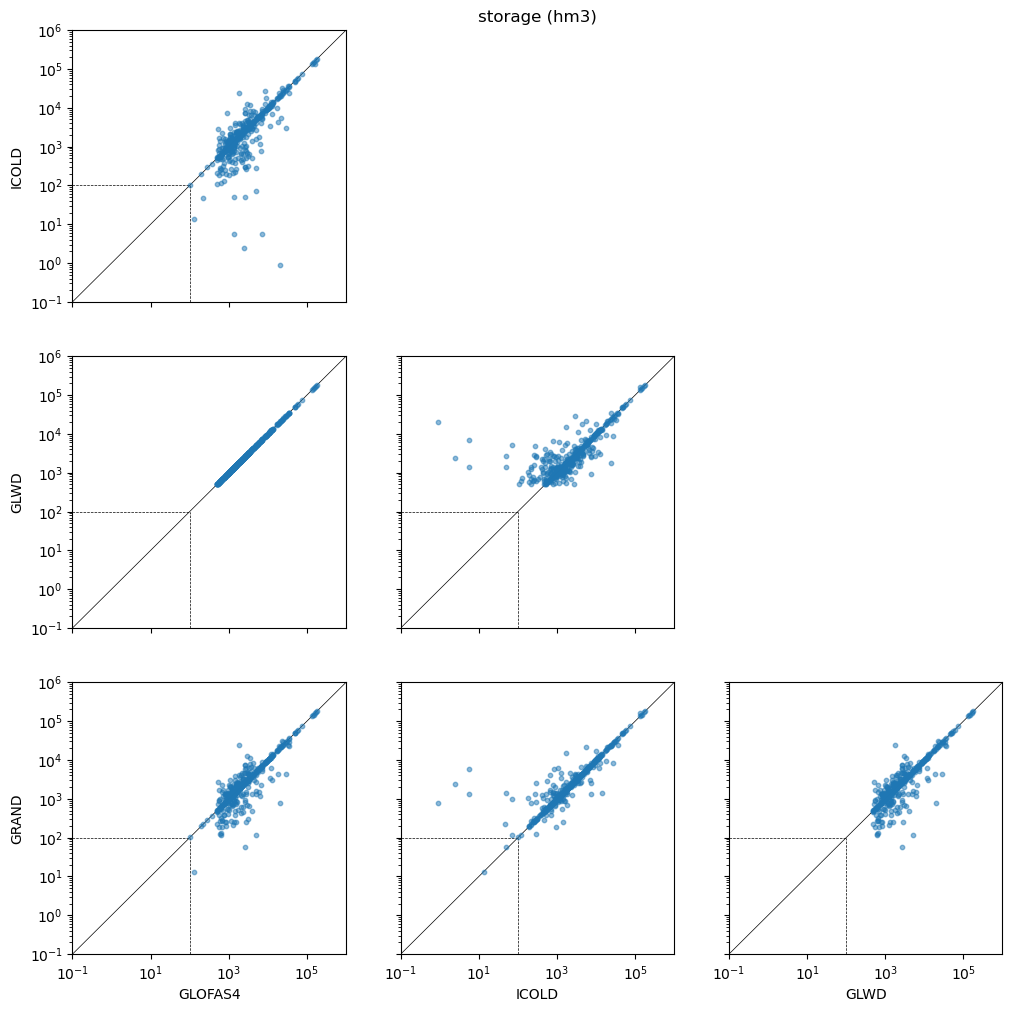

In [47]:
compare_attributes(
    capacity[['GLOFAS4', 'ICOLD', 'GLWD', 'GRAND']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)',
    scale='log',
)
plt.savefig(PATH_OUT / 'plots' / 'storage_pairplot.jpg', dpi=300, bbox_inches='tight')

The values in GLWD and GloFAS4 are identical. However, GRanD values are often different; in some cases, the difference is one order of magnitude. I've checked some of the largest differences and, in all but one case, GRanD was the correct source.

In [80]:
glofas5.loc[1068]

RES_ID                            2
LAK_ID                         <NA>
GRAND_ID                        408
GLWD_ID                        <NA>
INT_CODE                  I18703253
geometry    POINT (-114.925 42.825)
Name: 1068, dtype: object

In [48]:
capacity.sort_values('GLOFAS4')

,GLOFAS4,GRAND,GLWD,ICOLD,GLOFAS5,SOURCE
ID,,,,,,
1192,102.6,102.6,NaN,102.600,NaN,nan
1195,130.0,13.4,NaN,13.445,NaN,nan
1185,198.3,198.3,NaN,195.050,NaN,nan
1182,220.0,220.0,NaN,48.000,NaN,nan
1112,280.0,277.0,NaN,290.000,NaN,nan
...,...,...,...,...,...,...
1176,NaN,245.0,NaN,NaN,NaN,nan
1177,NaN,244.2,NaN,NaN,NaN,nan
1178,NaN,243.0,NaN,NaN,NaN,nan


In [49]:
error = 2
mask_error = (capacity.GRAND < capacity.GLOFAS4 / error) | (capacity.GRAND > error * capacity.GLOFAS4)
print(mask_error.sum())
capacity[mask_error]

70


,GLOFAS4,GRAND,GLWD,ICOLD,GLOFAS5,SOURCE
ID,,,,,,
29,1790.0,24350.0,1790.0,24352.000,NaN,nan
53,2960.0,12570.0,2960.0,12570.000,NaN,nan
61,3430.0,11520.0,3430.0,11520.000,NaN,nan
92,3570.0,7815.6,3570.0,8042.290,NaN,nan
94,2620.0,7560.0,2620.0,9294.765,NaN,nan
...,...,...,...,...,...,...
1190,5050.0,119.6,5050.0,70.000,NaN,nan
1191,620.0,117.5,620.0,117.500,NaN,nan
1193,2620.0,58.7,2620.0,49.638,NaN,nan


#### Select values

I have manually checked the large discrepancies between GLOFAS4 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from GLOFAS4.

In [50]:
mask = capacity.GRAND.isnull() & capacity.ICOLD.notnull()

In [51]:
pd.concat((glofas5.loc[mask], capacity[mask]), axis=1)

,RES_ID,LAK_ID,GRAND_ID,GLWD_ID,INT_CODE,geometry,GLOFAS4,GRAND,GLWD,ICOLD,GLOFAS5,SOURCE
ID,,,,,,,,,,,,
154,488,<NA>,<NA>,571,I18701848,POINT (-98.57500 43.07500),4690.0,NaN,4690.0,7770.924,NaN,nan
216,439,<NA>,<NA>,2921,I18702548,POINT (-120.72500 45.72500),3260.0,NaN,3260.0,3120.704,NaN,nan
305,347,<NA>,<NA>,974,I03100808,POINT (-74.17500 47.52500),2220.0,NaN,2220.0,407.000,NaN,nan
370,299,<NA>,<NA>,705,I00900187,POINT (142.37500 -32.37500),1790.0,NaN,1790.0,1794.000,NaN,nan
542,150,<NA>,<NA>,2045,I18703459,POINT (-119.27500 45.92500),1100.0,NaN,1100.0,1665.198,NaN,nan
565,130,<NA>,<NA>,2620,I18711024,POINT (-91.07500 43.22500),1020.0,NaN,1020.0,579.736,NaN,nan
650,86,<NA>,<NA>,2236,I18705949,POINT (-119.97500 46.87500),830.0,NaN,830.0,981.850,NaN,nan
684,72,<NA>,<NA>,3470,I18711022,POINT (-91.32500 43.87500),750.0,NaN,750.0,129.515,NaN,nan
706,60,<NA>,<NA>,3612,I18711023,POINT (-91.22500 43.57500),700.0,NaN,700.0,320.705,NaN,nan


In [52]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLOFAS4', 'ICOLD']:
    missing = capacity.GLOFAS5.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'GLOFAS5'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

In [53]:
capacity.GLOFAS5.isnull().sum(), capacity.SOURCE.value_counts()

(0,
 GRAND      1168
 GLOFAS4      28
 Name: SOURCE, dtype: int64)

2 reservoirs do not comply with the minimum storage of 100 hm3


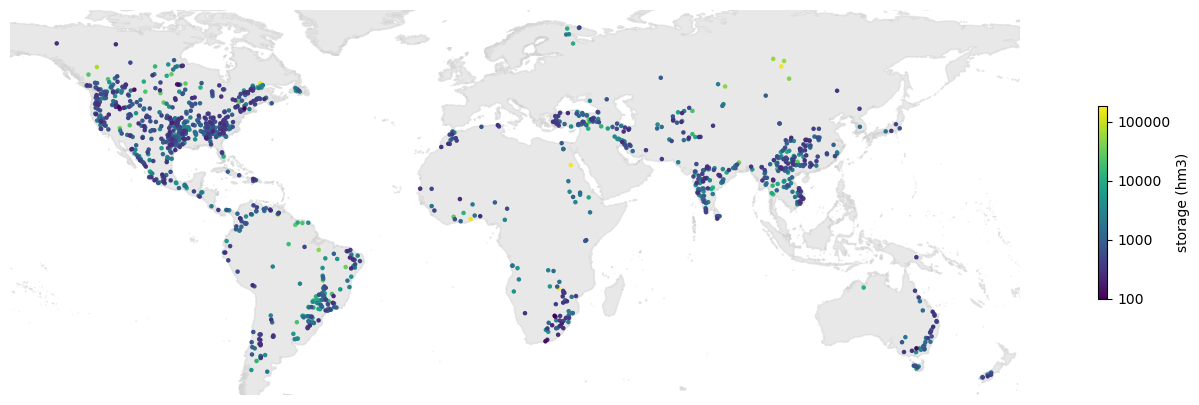

In [54]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(capacity.GLOFAS5),
    cmap='viridis',
    s=5,
    vmin=np.log10(MIN_VOLUME),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='storage (hm3)')
ticks = [2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'storage_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[capacity.index, ['CAP_MCM', 'CAP_SRC']] = capacity[['GLOFAS5', 'SOURCE']].values

print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format((glofas5.CAP_MCM < MIN_VOLUME).sum(),
                                                                                MIN_VOLUME))

### Catchment area

In [55]:
catchment = pd.DataFrame(index=glofas5.index, columns=['UPAREA', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
catchment.SOURCE = catchment.SOURCE.astype(str)

# upstream area map
for ID, point in glofas5.geometry.items():
    catchment.loc[ID, 'UPAREA'] = uparea.sel(x=point.x, y=point.y, method='nearest').item() * 1e-6

# GRanD
catchment.loc[grand.index, 'GRAND'] = grand.CATCH_SKM

# GLWD
catchment.loc[glwd.index, 'GLWD'] = glwd.CATCH_TSKM * 1e3

# ICOLD
catchment.loc[icold.index, 'ICOLD'] = icold.Catch_Area.values

#### Comparison

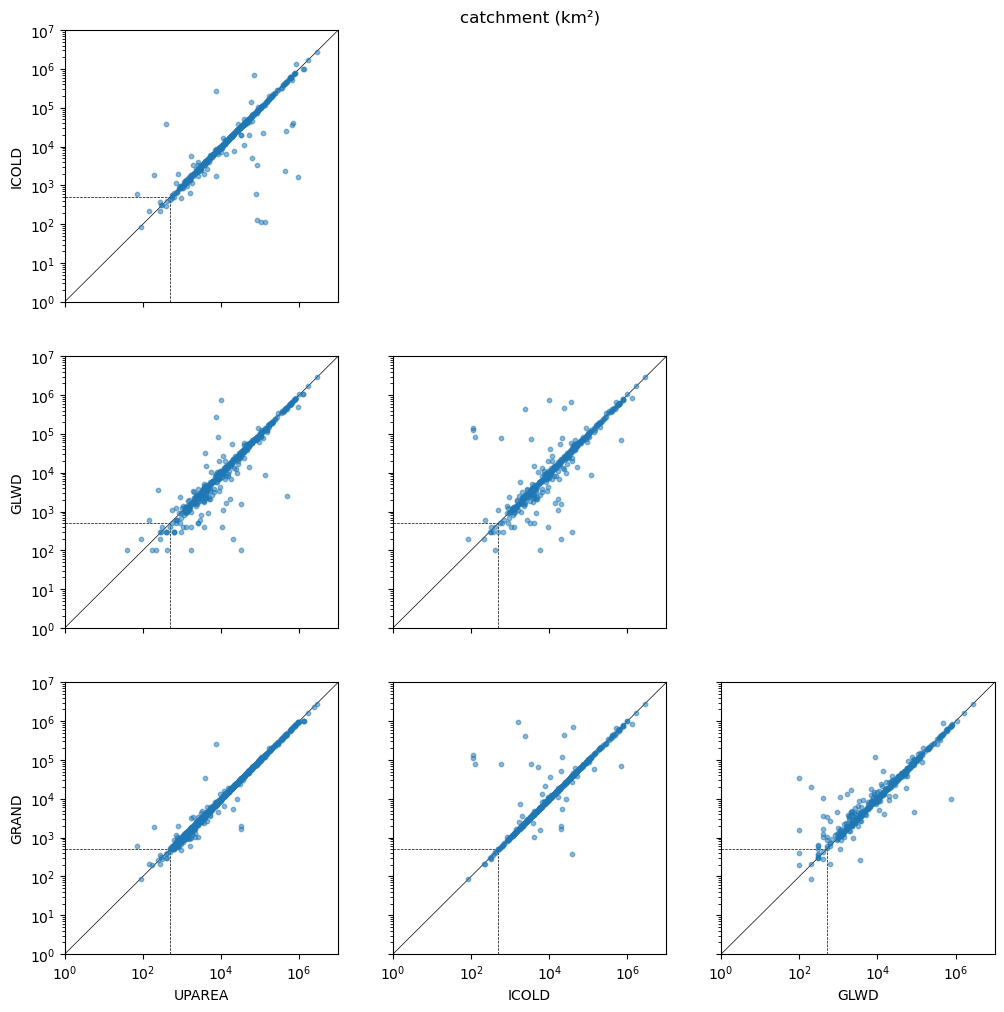

In [56]:
compare_attributes(
    catchment[['UPAREA', 'ICOLD', 'GLWD', 'GRAND']],
    thr=MIN_CATCHMENT,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

In [68]:
error = 1.5
mask_error = (catchment.GRAND < catchment.UPAREA / error) | (catchment.GRAND > error * catchment.UPAREA)
print(mask_error.sum())
catchment[mask_error]

26


,UPAREA,GRAND,GLWD,ICOLD,GLOFAS5,SOURCE
ID,,,,,,
64,2528.239616,1050.0,500.0,4030.0,1050.0,GRAND
139,1975.859968,3352.0,3300.0,3350.0,3352.0,GRAND
150,4393.073152,2673.0,3500.0,2673.0,2673.0,GRAND
159,7356.933120,265491.0,268000.0,265491.0,265491.0,GRAND
187,8448.251904,4607.0,85000.0,NaN,4607.0,GRAND
196,3188.858880,4908.0,NaN,NaN,4908.0,GRAND
206,26034.946048,10078.0,9900.0,26190.0,10078.0,GRAND
213,3609.999616,2356.0,2600.0,3760.0,2356.0,GRAND
251,33121.726464,1681.0,1600.0,20000.0,1681.0,GRAND


In [59]:
foo = pd.concat(
    (glofas5[mask_error][['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']],
     np.round(catchment[mask_error][['UPAREA', 'GRAND', 'GLWD', 'ICOLD']], 0)),
    axis=1
).sort_values('GRAND_ID')

In [60]:
foo

,RES_ID,LAK_ID,GRAND_ID,GLWD_ID,INT_CODE,geometry,UPAREA,GRAND,GLWD,ICOLD
ID,,,,,,,,,,
159,629,<NA>,702,72,I03101779,POINT (-98.87500 56.87500),7357.0,265491.0,268000.0,265491.0
940,<NA>,<NA>,1373,<NA>,I11300554,POINT (-100.17500 19.22500),1599.0,617.0,NaN,620.0
1079,<NA>,<NA>,1655,<NA>,I18700726,POINT (-84.07500 39.47500),72.0,625.0,NaN,614.0
1013,<NA>,<NA>,1930,<NA>,NaN,POINT (-81.32500 28.12500),2119.0,1047.0,NaN,NaN
251,399,<NA>,2340,379,I00700054,POINT (-68.67500 -38.52500),33122.0,1681.0,1600.0,20000.0
459,<NA>,<NA>,2341,<NA>,I00700079,POINT (-68.52500 -38.62500),33508.0,2049.0,NaN,20000.0
1188,46,<NA>,4321,3633,NaN,POINT (24.57500 -33.72500),3882.0,33621.0,32600.0,NaN
206,577,<NA>,4351,242,I14400032,POINT (32.27500 66.77500),26035.0,10078.0,9900.0,26190.0
333,<NA>,<NA>,4352,<NA>,I14400019,POINT (31.37500 66.67500),20067.0,5489.0,NaN,20871.0


In [ ]:
# foo.to_file(PATH_OUT / 'errors_area.shp')

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

In [61]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLWD', 'ICOLD', 'UPAREA']:
    missing = catchment.GLOFAS5.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'GLOFAS5'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source

In [62]:
catchment.GLOFAS5.isnull().sum(), catchment.SOURCE.value_counts()

(0,
 GRAND     1168
 GLWD        27
 UPAREA       1
 Name: SOURCE, dtype: int64)

C:\DEV\Anaconda3\envs\xr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 reservoirs do not comply with the minimum catchment area of 500 km²


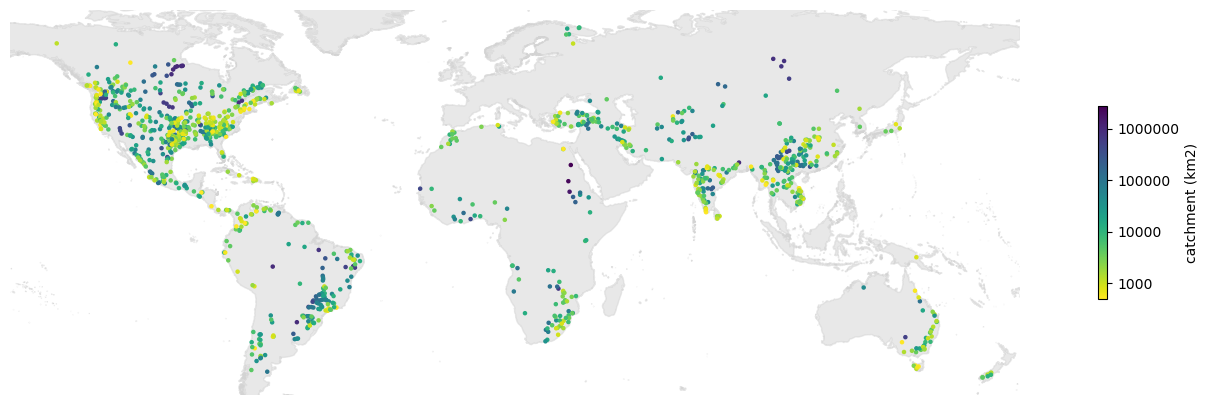

In [63]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(catchment.GLOFAS5),
    cmap='viridis_r',
    s=5,
    vmin=np.log10(MIN_CATCHMENT),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [3, 4, 5, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['GLOFAS5', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((glofas5.CATCH_SKM < MIN_CATCHMENT).sum(),
                                                                                       MIN_CATCHMENT))

In [66]:
PATH_OUT

WindowsPath('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tables')

In [67]:
glofas5.to_file(PATH_OUT / 'reservoirs_20241202.shp')

### Surface area

In [115]:
area = pd.DataFrame(index=glofas5.index, columns=['GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# GRanD
area.loc[grand.index, 'GRAND'] = grand.AREA_SKM

# GLWD
area.loc[glwd.index, 'GLWD'] = glwd.AREA_SKM

# ICOLD
area.loc[icold.index, 'ICOLD'] = icold.Res_Area.values * 1e-3

#### Comparison

C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1068: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\DEV\Anaconda3\envs\xr\lib\site-packages\matplotlib\axes\_axes.py:1069: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


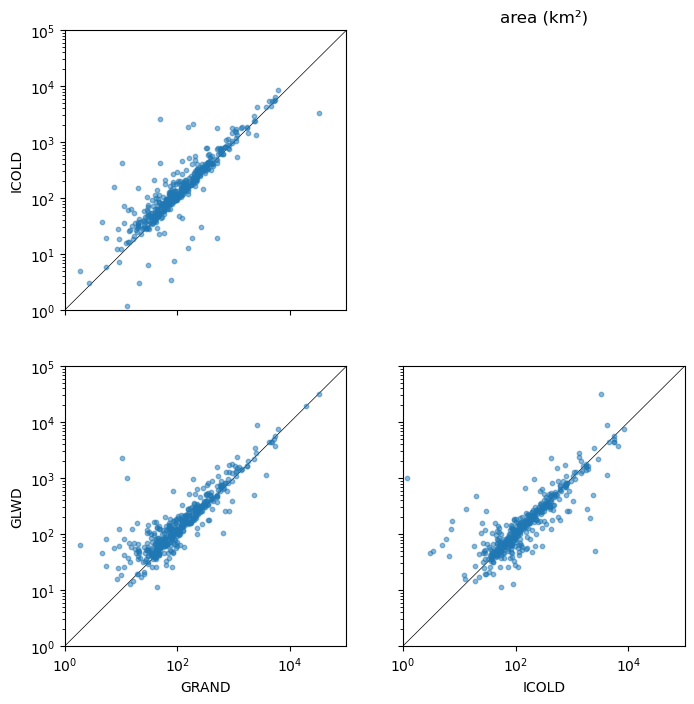

In [119]:
compare_attributes(
    area[['GRAND', 'ICOLD', 'GLWD']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e5,
    title='area (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

There is an eror in the units in some ICOLD values.

#### Select values

In [120]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLWD', 'ICOLD']:
    missing = area.GLOFAS5.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'GLOFAS5'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

In [121]:
area.GLOFAS5.isnull().sum(), area.SOURCE.value_counts()

(0,
 GRAND    1043
 GLWD       26
 Name: SOURCE, dtype: int64)

C:\DEV\Anaconda3\envs\xr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


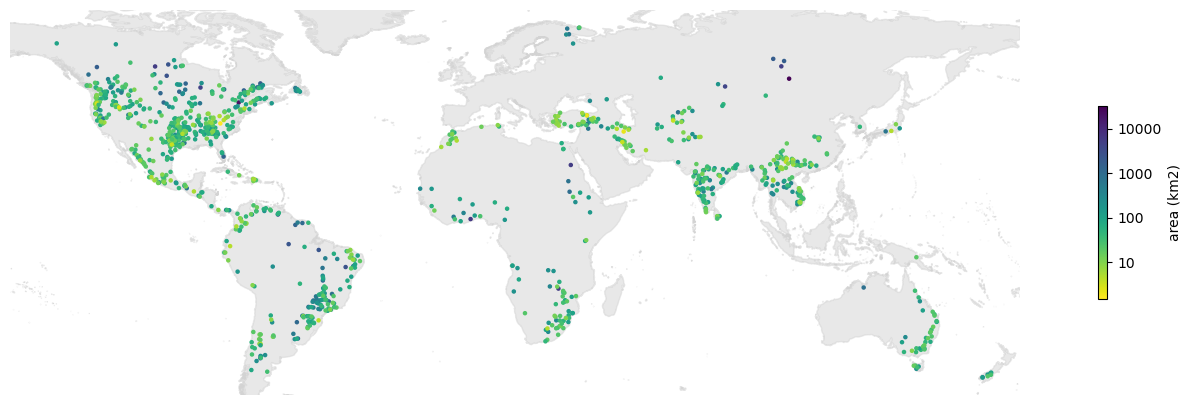

In [122]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(area.GLOFAS5),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [1, 2, 3, 4]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

In [123]:
# add values to GLOFAS5
glofas5.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['GLOFAS5', 'SOURCE']].values

### Mean inflow

I do not include the values reported in HydroLakes (`Dis_avg`) because they are identical to those in GRanD.

In [127]:
dis_avg = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GRAND', 'GLWD', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_avg.SOURCE = dis_avg.SOURCE.astype(str)

# GLOFAS4 reservoir parameter
dis_avg.loc[glofas4.index, 'GLOFAS4'] = glofas4.normq

# GLOFAS4 long-run average
for ID, point in glofas5.geometry.items():
    dis_avg.loc[ID, 'LTR'] = dis_avg_ltr.sel(x=point.x, y=point.y, method='nearest').item()

# GRanD
dis_avg.loc[mask.index, 'GRAND'] = grand.DIS_AVG_LS * 1e-3

# GLWD
dis_avg.loc[glwd.index, 'GLWD'] = glwd.INFLOW_CMS

#### Comparison

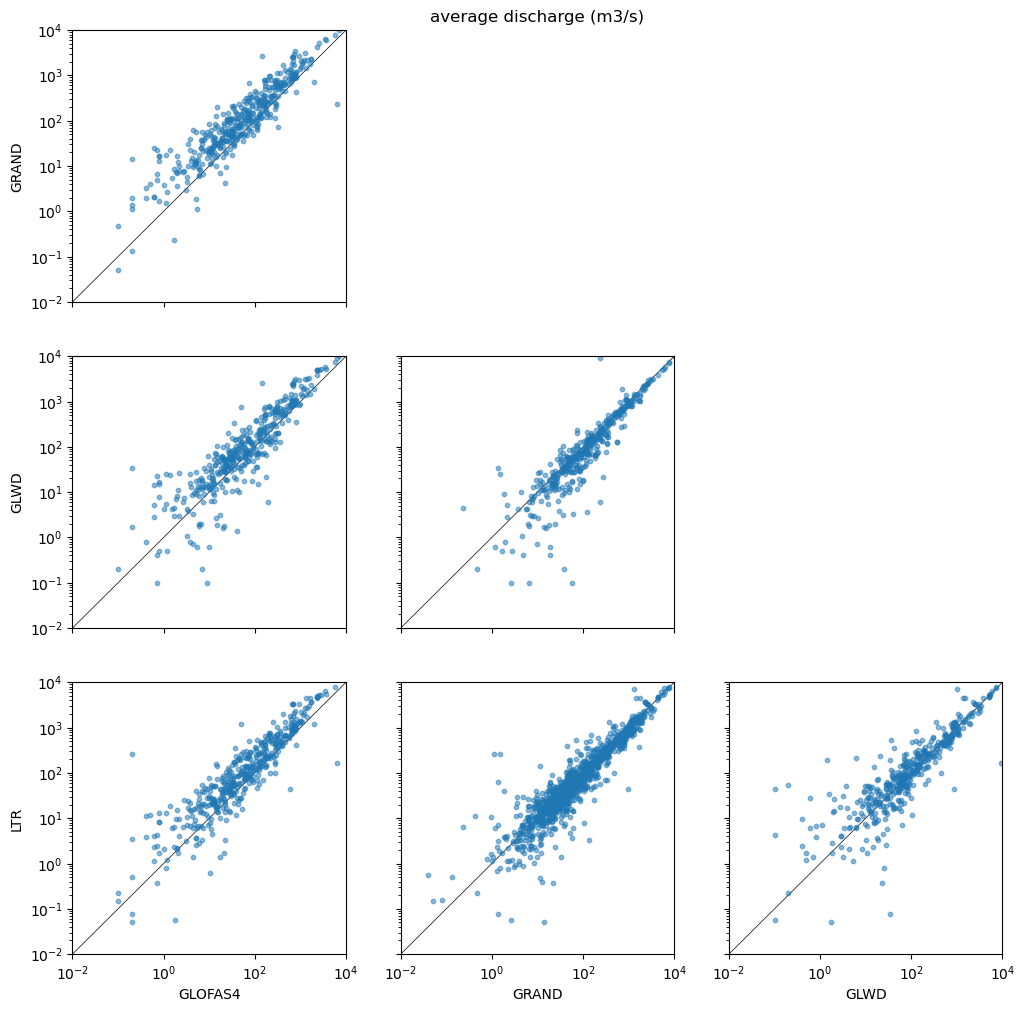

In [129]:
compare_attributes(
    dis_avg[['GLOFAS4', 'GRAND', 'GLWD', 'LTR']],
    thr=0,
    vmin=0.01,
    vmax=1e4,
    title='average discharge (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

In [132]:
error = 2
mask_error = (dis_avg.GRAND < dis_avg.LTR / error) | (dis_avg.GRAND > error * dis_avg.LTR)
print(mask_error.sum())
# catchment[mask_error]

foo = pd.concat(
    (glofas5[mask_error][['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']],
     np.round(dis_avg[mask_error][['GLOFAS4', 'LTR', 'GRAND', 'GLWD']], 0)),
    axis=1
).sort_values('GRAND_ID')

202


In [133]:
foo

,RES_ID,LAK_ID,GRAND_ID,GLWD_ID,INT_CODE,geometry,GLOFAS4,LTR,GRAND,GLWD
ID,,,,,,,,,,
633,<NA>,<NA>,19,<NA>,NaN,POINT (-122.82500 50.87500),NaN,51.0,22.0,NaN
629,179,<NA>,119,2253,I18709815,POINT (-121.07500 41.87500),5.0,6.0,1.0,1.0
860,<NA>,<NA>,193,<NA>,NaN,POINT (-120.82500 38.12500),NaN,5.0,13.0,NaN
219,250,<NA>,198,3721,I18703847,POINT (-120.52500 37.92500),13.0,18.0,42.0,39.0
252,374,<NA>,210,3697,I18701474,POINT (-120.42500 37.67500),16.0,26.0,58.0,50.0
...,...,...,...,...,...,...,...,...,...,...
247,<NA>,<NA>,7179,<NA>,NaN,POINT (82.82500 43.87500),NaN,62.0,1.0,NaN
853,<NA>,<NA>,7205,<NA>,NaN,POINT (108.92500 13.02500),NaN,171.0,350.0,NaN
783,<NA>,<NA>,7273,<NA>,NaN,POINT (102.47500 25.87500),NaN,32.0,10.0,NaN


#### Select values
I will use in all cases the average flow in the long-term run.

21 reservoirs have an average inflow below 1 m3/s


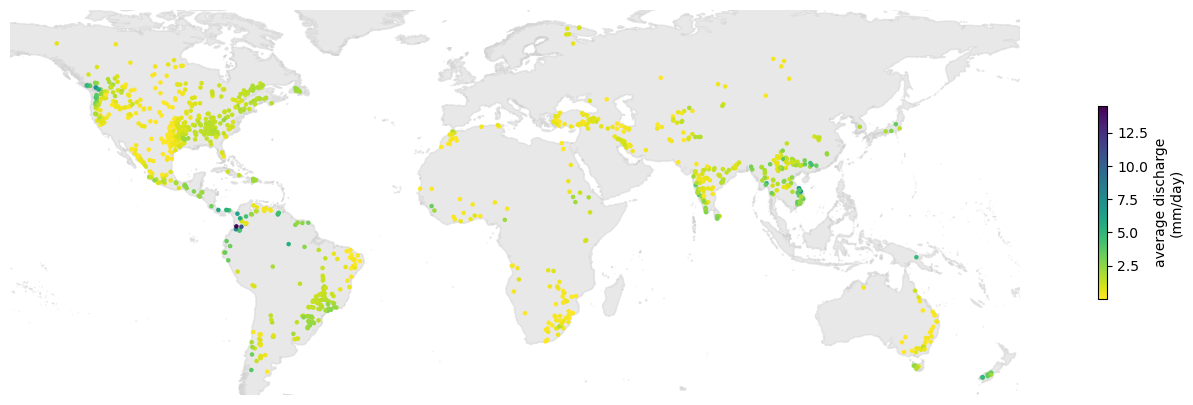

In [134]:
# select values from the GLOFAS4 long-term run
dis_avg.GLOFAS5 = dis_avg.LTR
dis_avg.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_avg.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_avg.index, 'DISAVG_CMS'] = dis_avg['GLOFAS5'].round(1).values

print('{0} reservoirs have an average inflow below 1 m3/s'.format((glofas5.DISAVG_CMS < 1).sum()))

### Degree of regulation

The degree of regulation is the amount of annual inflow that the reservoir can store. I'll cap this value to 100 years (same as GRanD does), since it's not feasible that a reservoir was designed to store that amount of water.

In [139]:
grand.DOR_PC

ID
1014     72.7
6       201.8
27      621.1
633     103.6
517      53.4
        ...  
992       9.3
562     398.2
622      87.8
865       3.5
749      17.6
Name: DOR_PC, Length: 1043, dtype: float64

In [145]:
dor = pd.DataFrame(index=glofas5.index, columns=['GLOFAS5', 'GRAND', 'GLWD'], dtype=float)

# GLOFAS5
dor['GLOFAS5'] = np.minimum(glofas5.CAP_MCM * 1e6 / (glofas5.DISAVG_CMS  * 24 * 3600 * 365), 100)

# GRanD
dor.loc[grand.index, 'GRAND'] = grand.DOR_PC.values / 100

# GLWD
dor.loc[glwd.index, 'GLWD'] = np.minimum(glwd.VOLUME_CKM * 1e9 / (glwd.INFLOW_CMS * 24 * 3600 * 365), 100)

#### Comparison

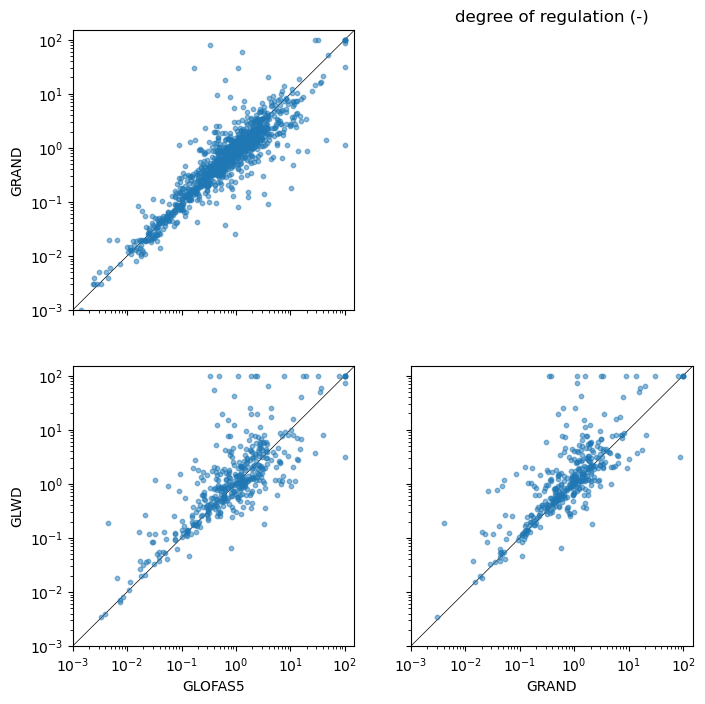

In [155]:
compare_attributes(
    dor[['GLOFAS5', 'GRAND', 'GLWD']],
    thr=0,
    vmin=0.001,
    vmax=150,
    title='degree of regulation (-)'
)
plt.savefig(PATH_OUT / 'plots' / 'dor_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

I will use the values obtained from the attributes in GLOFAS5.

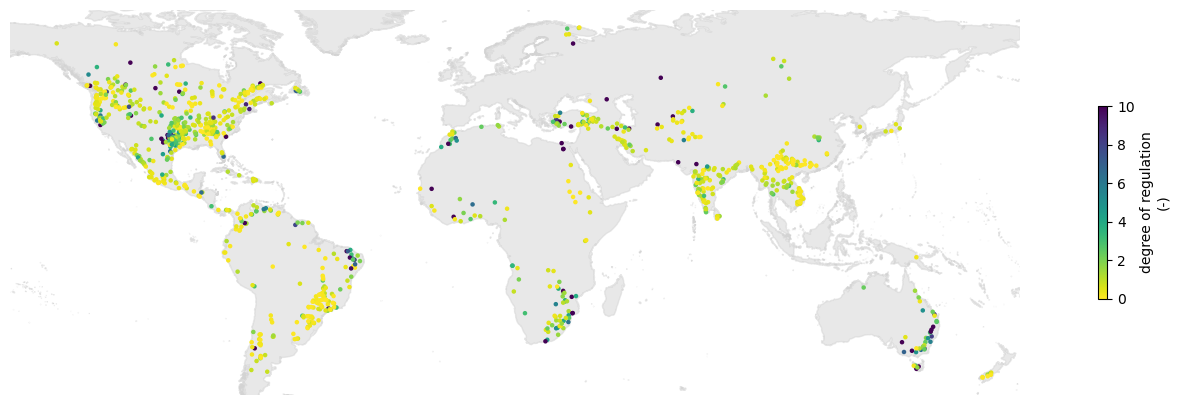

In [156]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dor.GLOFAS5,
    cmap='viridis_r',
    s=5,
    vmin=0,
    vmax=10
)
cbar = plt.colorbar(sct, shrink=.5, label='degree of regulation\n(-)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dor_map.jpg', dpi=300, bbox_inches='tight')

In [157]:
glofas5['DOR'] = dor.GLOFAS5.round(3)

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format((glofas5.DOR < MIN_DOR).sum(),
                                                                                       MIN_DOR))
print('{0} reservoirs have a degree of regulation larger than 10 years'.format((glofas5.DOR > 10).sum()))

141 reservoirs do not comply with the minimum degree of regulation 0.08
47 reservoirs have a degree of regulation larger than 10 years


There are problems in the computation of the degree of regulation, inherited either from the reservoir storage or the average inflow. It's not realistic that 96 reservoirs were designed to store 10 years of inflow.

### 100-year return period

In [158]:
dis_100 = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_100.SOURCE = dis_100.SOURCE.astype(str)

# GLOFAS4
dis_100.loc[glofas4.index, 'GLOFAS4'] = glofas4.ndq
    
# GLOFAS4 long-run average
for ID, point in glofas5.geometry.items():
    dis_100.loc[ID, 'LTR'] = dis_100_ltr.sel(x=point.x, y=point.y, method='nearest').item()

#### Comparison

In [186]:
def compare_attributes(df, thr, vmin, vmax, **kwargs):
    """Pair plot comparing the attribute values in different data sources
    
    Parameters:
    -----------
    df: pandas.DataFrame
        Values of an attributes in different data sources (columns)
    thr: float
        Minimum value of the attribute used in the selection
    vmin: float
        Minimum attribute value to be plotted
    vmax: float
        Maximum attribute value to be plotted
    """
    
    figsize = kwargs.get('figsize', (4, 4))
    scale = kwargs.get('scale', 'log')
    
    cols = df.columns
    ncols = len(cols) - 1
    
    fig, axes = plt.subplots(ncols=ncols, nrows=ncols, figsize=(ncols * figsize[0], ncols * figsize[1]), sharex=True, sharey=True)   
    if ncols == 1:
        axes = np.array([[axes]])
        
    for i, ax in enumerate(axes.flatten()):
        r = int(i / ncols)
        c = i % ncols
        if c > r:
            ax.axis('off')
            continue
        colx = cols[c]
        coly = cols[i + 1]
        ax.plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
        ax.vlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
        ax.hlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
        ax.scatter(df[colx], df[coly], s=10, alpha=.5)
        ax.set_xscale(scale)
        ax.set_yscale(scale)
        if c == 0:
            ax.set_ylabel(coly)
        if r == ncols - 1:
            ax.set_xlabel(colx)

        ax.set(
            xlim=(vmin, vmax),
            ylim=(vmin, vmax),
        );
    
    if 'title' in kwargs:
        fig.suptitle(kwargs['title']);

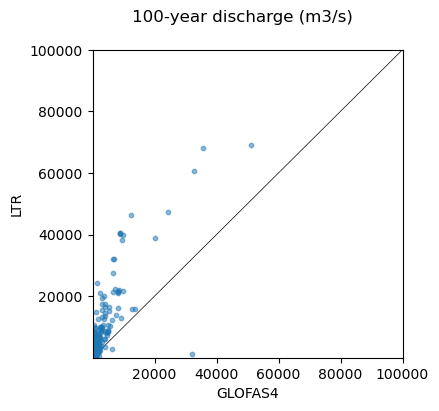

In [188]:
compare_attributes(
    dis_100[['GLOFAS4', 'LTR']],
    thr=0,
    vmin=0.1,
    vmax=1e5,
    title='100-year discharge (m3/s)',
    scale='linear'
)
# plt.savefig(PATH_OUT / 'plots' / 'dis_100_pairplot.jpg', dpi=300, bbox_inches='tight');

In [189]:
(dis_100.LTR / dis_100.GLOFAS4).median()

3.2631683147129316

In [193]:
glofas5.loc[(dis_100.GLOFAS4 / dis_100.LTR).idxmax()]

RES_ID                          118
LAK_ID                         <NA>
GRAND_ID                       <NA>
GLWD_ID                        2745
INT_CODE                        NaN
geometry      POINT (29.875 31.125)
CAP_MCM                       980.0
CAP_SRC                     GLOFAS4
CATCH_SKM                       0.0
CATCH_SRC                      GLWD
AREA_SKM                       66.0
AREA_SRC                       GLWD
DISAVG_CMS                      0.1
DOR                           100.0
Name: 533, dtype: object

#### Select values

11 reservoirs have an 100-year inflow below 10 m3/s


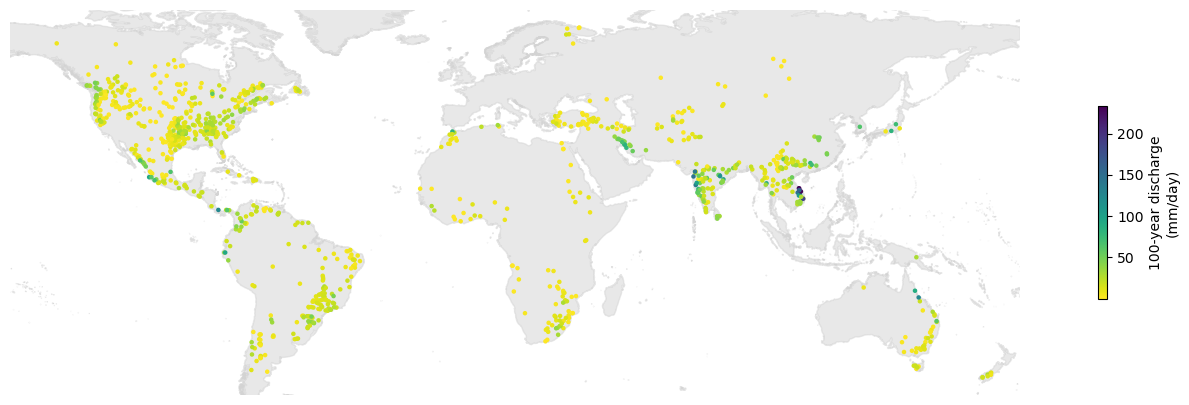

In [194]:
# select values from the GLOFAS4 long-term run
dis_100.GLOFAS5 = dis_100.LTR
dis_100.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_100.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='100-year discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_100_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_100.index, 'DIS100_CMS'] = dis_100['GLOFAS5'].round(1).values

print('{0} reservoirs have an 100-year inflow below 10 m3/s'.format((glofas5.DIS100_CMS < 10).sum()))

### Environment flow

In [195]:
dis_env = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_env.SOURCE = dis_env.SOURCE.astype(str)

# GLOFAS4
dis_env.loc[glofas4.index, 'GLOFAS4'] = glofas4.minq

# GLOFAS4 long-term run
# dis_env['LTR'] = dis_nat.sel(time=slice('2000-01-01', None)).quantile(.1, dim='time').to_pandas()

# # GLOFAS4 naturalised run
# for ID, point in glofas5.geometry.items():
#     dis_env.loc[ID, 'D2'] = dis_env_nat.sel(lon=point.x, lat=point.y, method='nearest').item()

In [196]:
dis_env.describe()

,GLOFAS4,LTR,GLOFAS5
count,441.000000,0.0,0.0
mean,131.995465,NaN,NaN
std,385.604419,NaN,NaN
min,0.000000,NaN,NaN
25%,4.200000,NaN,NaN
50%,17.800000,NaN,NaN
75%,81.800000,NaN,NaN
max,3869.800000,NaN,NaN


#### Comparison

In [ ]:
compare_attributes(
    dis_env[['GLOFAS4', 'LTR']],
    thr=0,
    vmin=1e-4,
    vmax=1e4,
    title='environmental discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_env_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

I will select the values extracted from the D2 map, as it limits extremely low values.

In [ ]:
# select values from the GLOFAS4 naturalised run
dis_env.GLOFAS5 = dis_env.D2
dis_env.SOURCE = 'GLOFAS4_nat'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_env.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='environmental discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_env_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_env.index, 'DISENV_CMS'] = dis_env['GLOFAS5'].round(4).values

print('{0} reservoirs have an environmental flow below 0.1 m3/s'.format((glofas5.DISENV_CMS < 0.1).sum()))

There are very low values of environmental flow.

## Export

In [197]:
glofas4.columns

Index(['ResID', 'GLWD_ID', 'GRAND_ID', 'Source', 'LAKE_NAME', 'DAM_NAME',
       'LONG_DEG', 'LAT_DEG', 'LONG_OUTLE', 'LAT_OUTLET', 'VOLUME_Gra',
       'VOL_SRC', 'COUNTRY', 'SEC_CNTRY', 'RIVER', 'NEAR_CITY', 'DAM_YEAR',
       'note', 'X_coord', 'Y_coord', 'X_CORRECT', 'Y_CORRECT', 'LisfloodX3',
       'LisfloodY3', 'remap_com', 'clim', 'flim', 'minq', 'ndq', 'nlim',
       'normq', 'stor', 'geometry', 'ID'],
      dtype='object')

In [208]:
# copy glofas5 as main source
reservoirs = glofas5.copy()

# LISFLOOD coordinates
reservoirs['LisfloodX'] = reservoirs.geometry.x
reservoirs['LisfloodY'] = reservoirs.geometry.y

# source of discharge data
reservoirs['DIS_SRC'] = 'GLOFAS4_ltr'

# add data from GRanD
grand_ids = reservoirs.GRAND_ID.dropna()
grand_cols = ['RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR', 'LONG_DD', 'LAT_DD']
reservoirs.loc[grand_ids.index, grand_cols] = grand.loc[grand_ids.index, grand_cols].values

# add info from GLOFAS4
ids = reservoirs[reservoirs.GRAND_ID.isnull() & reservoirs.RES_ID.notnull()].index
cols_glofas4 = ['COUNTRY', 'DAM_NAME', 'RIVER']
reservoirs.loc[ids, cols_glofas4] = glofas4.loc[ids, cols_glofas4]

# reorder and rename columns
cols = ['RES_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 
        'RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR',
        'LONG_DD', 'LAT_DD', 'LisfloodX', 'LisfloodY',
        'CAP_MCM', 'CAP_SRC', 'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', #'DISENV_CMS',
        'DISAVG_CMS', 'DIS100_CMS', 'DIS_SRC', 'DOR',
        'geometry']
reservoirs = reservoirs[cols]

# adapt dtypes
reservoirs.YEAR = reservoirs.YEAR.astype('Int64')

In [212]:
# reset index
# reservoirs['FID'] = np.arange(1, reservoirs.shape[0] + 1)
# reservoirs.loc[reservoirs.ResID > 5000, 'FID'] = reservoirs.loc[reservoirs.ResID > 5000, 'ResID']
idx = []
i = glofas4.ResID.max()
for res_id in reservoirs.RES_ID.values:
    if pd.isna(res_id):
        i += 1
        idx.append(i)
    else:
        idx.append(res_id)
reservoirs['FID'] = idx
reservoirs.set_index('FID', drop=True, inplace=True)
reservoirs.sort_index(axis=0, inplace=True)

In [213]:
mask_res = (reservoirs.DOR >= MIN_DOR) | ((reservoirs.index > 5000) & (reservoirs.index < 6000)) | (reservoirs.AREA_SKM.isnull())
print('{0} reservoirs will be modelled as lakes'.format((~mask_res).sum()))

141 reservoirs will be modelled as lakes


In [ ]:
with pd.ExcelWriter(PATH_OUT / 'glofas5_reservoirs.xlsx', engine='openpyxl') as writer:
    # Reservoirs in GLOFAS5 (as reservoirs)
    reservoirs[mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_reservoirs', float_format='%.4f')
    
    # Reservoirs modeled as lakes in GLOFAS5 (as lakes)
    reservoirs[~mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_lakes', float_format='%.4f')